In [2]:
import pandas as pd
from sqlalchemy import create_engine

# Use SQLAlchemy engine (instead of pyodbc)
engine = create_engine(
    "mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

# Query the customers table
query = "SELECT * FROM orders" 
df = pd.read_sql(query, engine)

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [3]:
query = """
SELECT 
    FORMAT(CAST(order_purchase_timestamp AS DATETIME), 'yyyy-MM') AS order_month,
    COUNT(order_id) AS total_orders
FROM orders
WHERE YEAR(CAST(order_purchase_timestamp AS DATETIME)) = 2018
GROUP BY FORMAT(CAST(order_purchase_timestamp AS DATETIME), 'yyyy-MM')
ORDER BY order_month
"""

df = pd.read_sql(query, engine)
df.head()

# -- GROUP BY + TIME EXTRACT
# -- Question: Count the number of orders per month in 2018.
# -- When to Use: Use CAST to ensure date type and FORMAT to group by year-month.

,order_month,total_orders
0,2018-01,7269
1,2018-02,6728
2,2018-03,7211
3,2018-04,6939
4,2018-05,6873


#  Summary Table:
| **Clause** | **Purpose**                                     | **Use On**           | **When to Use**                                                     |
| ---------- | ----------------------------------------------- | -------------------- | ------------------------------------------------------------------- |
| `WHERE`    | Filters rows **before** grouping or sorting     | **Rows**             | Use to filter data based on conditions (`WHERE state = 'SP'`)       |
| `GROUP BY` | Aggregates rows into groups                     | **Rows**             | Use when summarizing data (`COUNT`, `SUM`, etc.) per category/group |
| `ORDER BY` | Sorts final output **after** filtering/grouping | **Columns (output)** | Use to order results (`ORDER BY total DESC`, `ORDER BY city ASC`)   |


In [6]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# "Count the number of orders placed in each month during the year 2018."

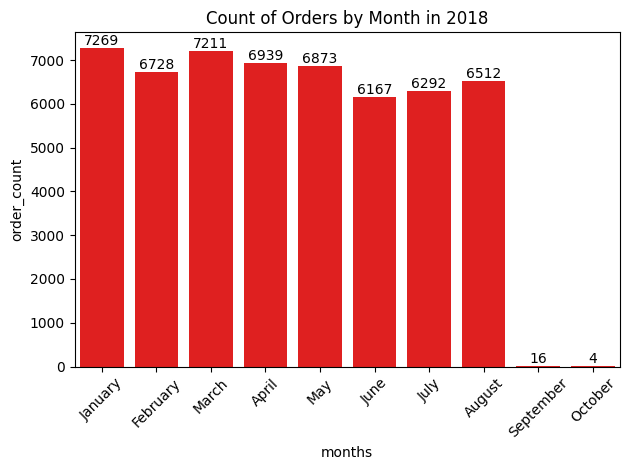

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

engine = create_engine(
    "mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

query = """
SELECT 
    DATENAME(MONTH, order_purchase_timestamp) AS months,
    COUNT(order_id) AS order_count
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY DATENAME(MONTH, order_purchase_timestamp), MONTH(order_purchase_timestamp)
ORDER BY MONTH(order_purchase_timestamp)
"""

df = pd.read_sql(query, engine)

ax = sns.barplot(x="months", y="order_count", data=df, color="red")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Month in 2018")
plt.tight_layout()
plt.show()

| **What to Use**           | **Why / When to Use**                           |
| ------------------------- | ----------------------------------------------- |
| `WHERE YEAR(date) = 2018` | Filters **rows** for a specific year (2018)     |
| `DATENAME(MONTH, date)`   | Extracts **month names** from a **date column** |
| `GROUP BY DATENAME(...)`  | Groups **rows** by month                        |
| `COUNT(order_id)`         | Counts number of **rows/orders** in each group  |
| `ORDER BY MONTH(date)`    | Sorts the **rows** by month number (Jan to Dec) |






#  Find the average number of products per order, grouped by customer city

In [9]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection
engine = create_engine(
    "mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

# Load tables
orders = pd.read_sql("SELECT order_id, customer_id FROM orders", engine)
customers = pd.read_sql("SELECT customer_id, customer_city FROM customers", engine)
order_items = pd.read_sql("SELECT order_id, product_id FROM order_items", engine)

# Merge the data
merged = orders.merge(customers, on="customer_id").merge(order_items, on="order_id")

# Count products per order in each city
order_product_counts = merged.groupby(["order_id", "customer_city"])["product_id"] \
                             .count().reset_index(name="products_count")

# Average number of products per order by city
avg_products = order_product_counts.groupby("customer_city")["products_count"] \
                                   .mean().reset_index(name="avg_products_per_order")

# Sort and display
avg_products = avg_products.sort_values(by="avg_products_per_order", ascending=False)
avg_products.head()

,customer_city,avg_products_per_order
2619,padre carvalho,7.0
907,celso ramos,6.5
1154,datas,6.0
756,candido godoi,6.0
2264,matias olimpio,5.0


# Calculate the percentage of total revenue contributed by each product category.

In [14]:
import pandas as pd
from sqlalchemy import create_engine

# SQL connection
engine = create_engine("mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")

# Query with total revenue column
query = """
SELECT 
    p.[product category],
    SUM(oi.price) AS category_revenue,
    total.total_revenue,
    ROUND(SUM(oi.price) * 100.0 / total.total_revenue, 2) AS revenue_percentage
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
CROSS JOIN (SELECT SUM(price) AS total_revenue FROM order_items) total
GROUP BY p.[product category], total.total_revenue
ORDER BY revenue_percentage DESC
"""

# Load into DataFrame
df = pd.read_sql(query, engine)
df.head()

,product category,category_revenue,total_revenue,revenue_percentage
0,HEALTH BEAUTY,1258681.34,1.359164e+07,9.26
1,Watches present,1205005.68,1.359164e+07,8.87
2,bed table bath,1036988.68,1.359164e+07,7.63
3,sport leisure,988048.97,1.359164e+07,7.27
4,computer accessories,911954.32,1.359164e+07,6.71


#  Question: Cities with more than 100 customers

| Clause     | Purpose                                               | Example Use                          |
| ---------- | ----------------------------------------------------- | ------------------------------------ |
| `GROUP BY` | Groups rows by a column                               | Group customers by city              |
| `HAVING`   | Filters groups based on aggregation (like COUNT, SUM) | Keep only cities with >100 customers |


In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Connect to SQL Server
engine = create_engine("mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")

# Query
query = """
SELECT customer_city, COUNT(customer_id) AS customer_count
FROM customers
GROUP BY customer_city
HAVING COUNT(customer_id) > 100
ORDER BY customer_count DESC
"""

# Load data into DataFrame
df = pd.read_sql(query, engine)
df.head()

# Classify payments as full or installment based on payment type.

In [15]:
import pandas as pd
from sqlalchemy import create_engine

# SQL connection
engine = create_engine("mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")

query = """
SELECT 
    payment_type,
    payment_installments,
    payment_value,
    CASE 
        WHEN payment_installments = 1 THEN 'Full Payment'
        ELSE 'Installment'
    END AS payment_category
FROM payments
"""

df = pd.read_sql(query, engine)
df.head()

,payment_type,payment_installments,payment_value,payment_category
0,credit_card,8,99.33,Installment
1,credit_card,1,24.39,Full Payment
2,credit_card,1,65.71,Full Payment
3,credit_card,8,107.78,Installment
4,credit_card,2,128.45,Installment


# 1. Label high-value orders as 'Premium' or 'Regular'

In [17]:
import pandas as pd
from sqlalchemy import create_engine

# SQL connection
engine = create_engine("mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")

query = """
SELECT 
    payment_type,
    payment_installments,
    payment_value,
    CASE 
        WHEN payment_value > 300 THEN 'Premium'
        ELSE 'Regular'
    END AS order_label
FROM payments
"""

df = pd.read_sql(query, engine)
df.head()

,payment_type,payment_installments,payment_value,order_label
0,credit_card,8,99.33,Regular
1,credit_card,1,24.39,Regular
2,credit_card,1,65.71,Regular
3,credit_card,8,107.78,Regular
4,credit_card,2,128.45,Regular


#  Mark customers as 'Active' if they placed more than 5 orders


In [18]:
query = """
SELECT 
    customer_id,
    COUNT(order_id) AS order_count,
    CASE 
        WHEN COUNT(order_id) > 5 THEN 'Active'
        ELSE 'Inactive'
    END AS customer_status
FROM orders
GROUP BY customer_id
"""

df = pd.read_sql(query, engine)
df.head()

,customer_id,order_count,customer_status
0,ab9fe017b1de9118ef7b8273ddbce479,1,Inactive
1,709cc21d90b1c1afba62d1bec7d2761b,1,Inactive
2,024528dfafe67bb6421ef6e6da9adc9e,1,Inactive
3,a60acdac62e9cf7ec389b37d8d81e948,1,Inactive
4,be32bd080b6202c0024e3065140711aa,1,Inactive


#  Classify delivery speed: Fast, Normal, Late

In [20]:
query = """
SELECT 
    order_delivered_customer_date,
    order_estimated_delivery_date,
    DATEDIFF(DAY, order_delivered_customer_date, order_estimated_delivery_date) AS delivery_gap,
    CASE 
        WHEN DATEDIFF(DAY, order_delivered_customer_date, order_estimated_delivery_date) >= 5 THEN 'Fast'
        WHEN DATEDIFF(DAY, order_delivered_customer_date, order_estimated_delivery_date) BETWEEN 0 AND 4 THEN 'Normal'
        ELSE 'Fast'
    END AS delivery_speed
FROM orders
WHERE order_delivered_customer_date IS NOT NULL
"""

df = pd.read_sql(query, engine)
df.head()


,order_delivered_customer_date,order_estimated_delivery_date,delivery_gap,delivery_speed
0,2017-10-10 21:25:13,2017-10-18 00:00:00,8,Fast
1,2018-08-07 15:27:45,2018-08-13 00:00:00,6,Fast
2,2018-08-17 18:06:29,2018-09-04 00:00:00,18,Fast
3,2017-12-02 00:28:42,2017-12-15 00:00:00,13,Fast
4,2018-02-16 18:17:02,2018-02-26 00:00:00,10,Fast


# DATEPART, FORMAT — Number of orders per month in 2018


| **SQL Tool**             | **Use Case**                                              |
| ------------------------ | --------------------------------------------------------- |
| `WHERE YEAR(...) = 2018` | Filter records to only include the year **2018**          |
| `DATEPART(MONTH, ...)`   | Extract **month number** (1–12) for chronological sorting |
| `FORMAT(..., 'MMMM')`    | Get **full month name** (e.g., January) for readability   |
| `GROUP BY`               | Group data by **month**                                   |
| `COUNT(order_id)`        | Count **total orders** in each group                      |
| `ORDER BY`               | Sort results **by month number**                          |



In [6]:
import pandas as pd
from sqlalchemy import create_engine

# Connect to SQL Server
engine = create_engine("mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")

query = """
SELECT 
    YEAR(order_purchase_timestamp) AS order_year,
    DATENAME(MONTH, order_purchase_timestamp) AS month_name,
    DATEPART(MONTH, order_purchase_timestamp) AS month_number,
    COUNT(order_id) AS order_count
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY 
    YEAR(order_purchase_timestamp),
    DATENAME(MONTH, order_purchase_timestamp), 
    DATEPART(MONTH, order_purchase_timestamp)
ORDER BY month_number
"""

df = pd.read_sql(query, engine)
df.drop(columns="month_number", inplace=True)  # optional
df.head()

,order_year,month_name,order_count
0,2018,January,7269
1,2018,February,6728
2,2018,March,7211
3,2018,April,6939
4,2018,May,6873


# Calculate the average revenue per product.

In [12]:
query = """
SELECT 
    p.[product category],
    AVG(oi.price) AS avg_revenue_per_product,
    SUM(oi.price) AS total_revenue,
    (SELECT SUM(price) FROM order_items) AS grand_total_revenue
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.[product category]
ORDER BY total_revenue DESC;
"""

df = pd.read_sql(query, engine)
df.head()

,product category,avg_revenue_per_product,total_revenue,grand_total_revenue
0,HEALTH BEAUTY,130.163531,1258681.34,1.359164e+07
1,Watches present,201.135984,1205005.68,1.359164e+07
2,bed table bath,93.296327,1036988.68,1.359164e+07
3,sport leisure,114.344285,988048.97,1.359164e+07
4,computer accessories,116.513903,911954.32,1.359164e+07


# ✅ Subqueries (inline) — Customers Who Placed More Than 3 Orders


| # | **Question**                      | **Answer**                                                                |
| - | --------------------------------- | ------------------------------------------------------------------------- |
| 1 | Who placed more than 3 orders?    | Use a **subquery** with `GROUP BY customer_id` and `HAVING COUNT(*) > 3`. |
| 2 | Why use a subquery here?          | Because we are filtering based on **aggregated data** (total orders).     |
| 3 | Where is the subquery used?       | Inside a `WHERE customer_id IN (...)` clause in the main query.           |
| 4 | Can we show customer details too? | Yes, by joining the subquery result with the `customers` table.           |


# Logic:

Step 1: Aggregate orders per customer


SELECT customer_id, COUNT(order_id) AS order_count
FROM orders
GROUP BY customer_id

step 2: Define a subquery:

FROM (
    SELECT customer_id, COUNT(order_id) AS order_count
    FROM orders
    GROUP BY customer_id
) AS customer_orders

This entire aggregated result is treated as a virtual table named customer_orders.

Step 3: Filter customers with more than 3 orders

WHERE order_count > 3

Step 4: Final selection:

SELECT customer_id, order_count



In [3]:
import pandas as pd
from sqlalchemy import create_engine

# Connect to SQL Server
engine = create_engine("mssql+pyodbc://NARENDRA\\SQLEXPRESS/sql_to_python?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")

# Subquery to get customers with more than 3 orders
query = """
SELECT customer_id, order_count
FROM (
    SELECT customer_id, COUNT(order_id) AS order_count
    FROM orders
    GROUP BY customer_id
) AS customer_orders
WHERE order_count > 3
ORDER BY order_count DESC
"""

# Load into DataFrame
df = pd.read_sql(query, engine)
df.head()

,customer_id,order_count
